In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random

from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [3]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

import os

In [4]:
tf.random.set_seed(79)
random.seed(65)
np.random.seed(85)

In [5]:
current_dir = "/home/u6/jiayanh/Downloads"
data_path = os.path.join(current_dir, "train.csv")
data = pd.read_csv(data_path)

In [6]:
train = data.sample(frac = 0.7)
test = data.sample(frac = 0.3)

In [7]:
# how many data points in each data file
print('Train', len(train))
print('Test', len(test))

Train 5329
Test 2284


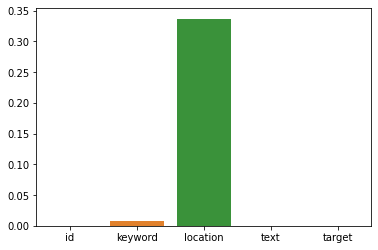

In [8]:
# plot missing data
sns.barplot(x = train.columns, y = train.isnull().mean())
plt.show()

In [9]:
# drop location and id columns
train.drop(columns = ['id', 'keyword', 'location'], inplace = True)
test.drop(columns = ['id', 'keyword','location'], inplace = True)
train.dropna(inplace = True)

In [10]:
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)
train.head(5)

,text,target
0,Exploration Takes Seismic Shift in #Gabon to #...,1
1,Mind blown by @GlassAnimals slithering viscous...,0
2,70 Years After Atomic Bombs Japan Still Strugg...,1
3,Just came back from camping and returned with ...,1
4,Dead Space - Obliteration Imminent [2/2]: http...,0


<function matplotlib.pyplot.show(close=None, block=None)>

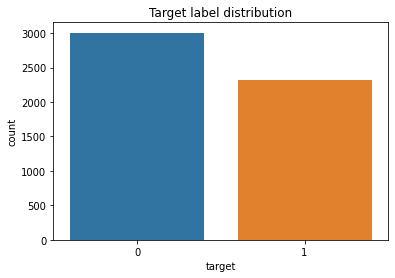

In [11]:
# see how the labels distributue
sns.countplot(x = 'target', data = train)
plt.title('Target label distribution')
plt.show

In [12]:
wordnet_lemmatizer = WordNetLemmatizer()

def quick_clean(text):
#     text = text + ' '
    #remove links
    text = re.sub(r'(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-&?=%.]+', '', text)
    #lower case
    text = text.lower()    
    #remove special characters
    text = re.sub(r'[\W]+', ' ', text)
    #remove double spaces
    text = re.sub(r'\s+', ' ', text)
    #tokenize
    text = word_tokenize(text)
    #remove stop words
    text = [word for word in text if not word in stopwords.words('english')]    
    #lemmatize
    text= [wordnet_lemmatizer.lemmatize(word, pos='v') for word in text]
    #rejoin text to string
    text = ' '.join(text)
    return text

def quick_clean_vectorized(col):
    return pd.DataFrame(data=col.apply(lambda x: quick_clean(x)).tolist())

quiklean_transformer = FunctionTransformer(quick_clean_vectorized) 

In [13]:
cleaned_df = quick_clean_vectorized(train['text'])

In [14]:
train['clean_text'] = cleaned_df[0]
train.drop(columns = ['text'], inplace = True)
train.head()

,target,clean_text
0,1,exploration take seismic shift gabon somalia
1,0,mind blow glassanimals slither viscous gold mi...
2,1,70 years atomic bomb japan still struggle war ...
3,1,come back camp return new song get record tomo...
4,0,dead space obliteration imminent 2 2 via youtube


In [15]:
len(train['target'])

5329

In [16]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train.clean_text)
X_train_counts.shape

(5329, 11770)

In [17]:
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape

(5329, 11770)

In [18]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(5329, 11770)

In [19]:
clf = MultinomialNB().fit(X_train_tfidf, train.target)

In [20]:
# test it out
doc_new = ['Accident on A27 near Lewes is it Kingston Roundabout rather than A283']
X_new_counts = count_vect.transform(doc_new)
X_new_tfidf = tfidf_transformer.transform(X_new_counts)
predicted = clf.predict(X_new_tfidf)
for doc, category in zip(doc_new, predicted):
     print('%r => %s' % (doc, train.target[category]))

'Accident on A27 near Lewes is it Kingston Roundabout rather than A283' => 0


In [21]:
text_clf = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()),
])

In [22]:
text_clf.fit(train.clean_text, train.target)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [23]:
predicted = text_clf.predict(test.text)

In [24]:
np.mean(predicted == test.target)

0.8677758318739054

In [27]:
cm = confusion_matrix(test.target, predicted)

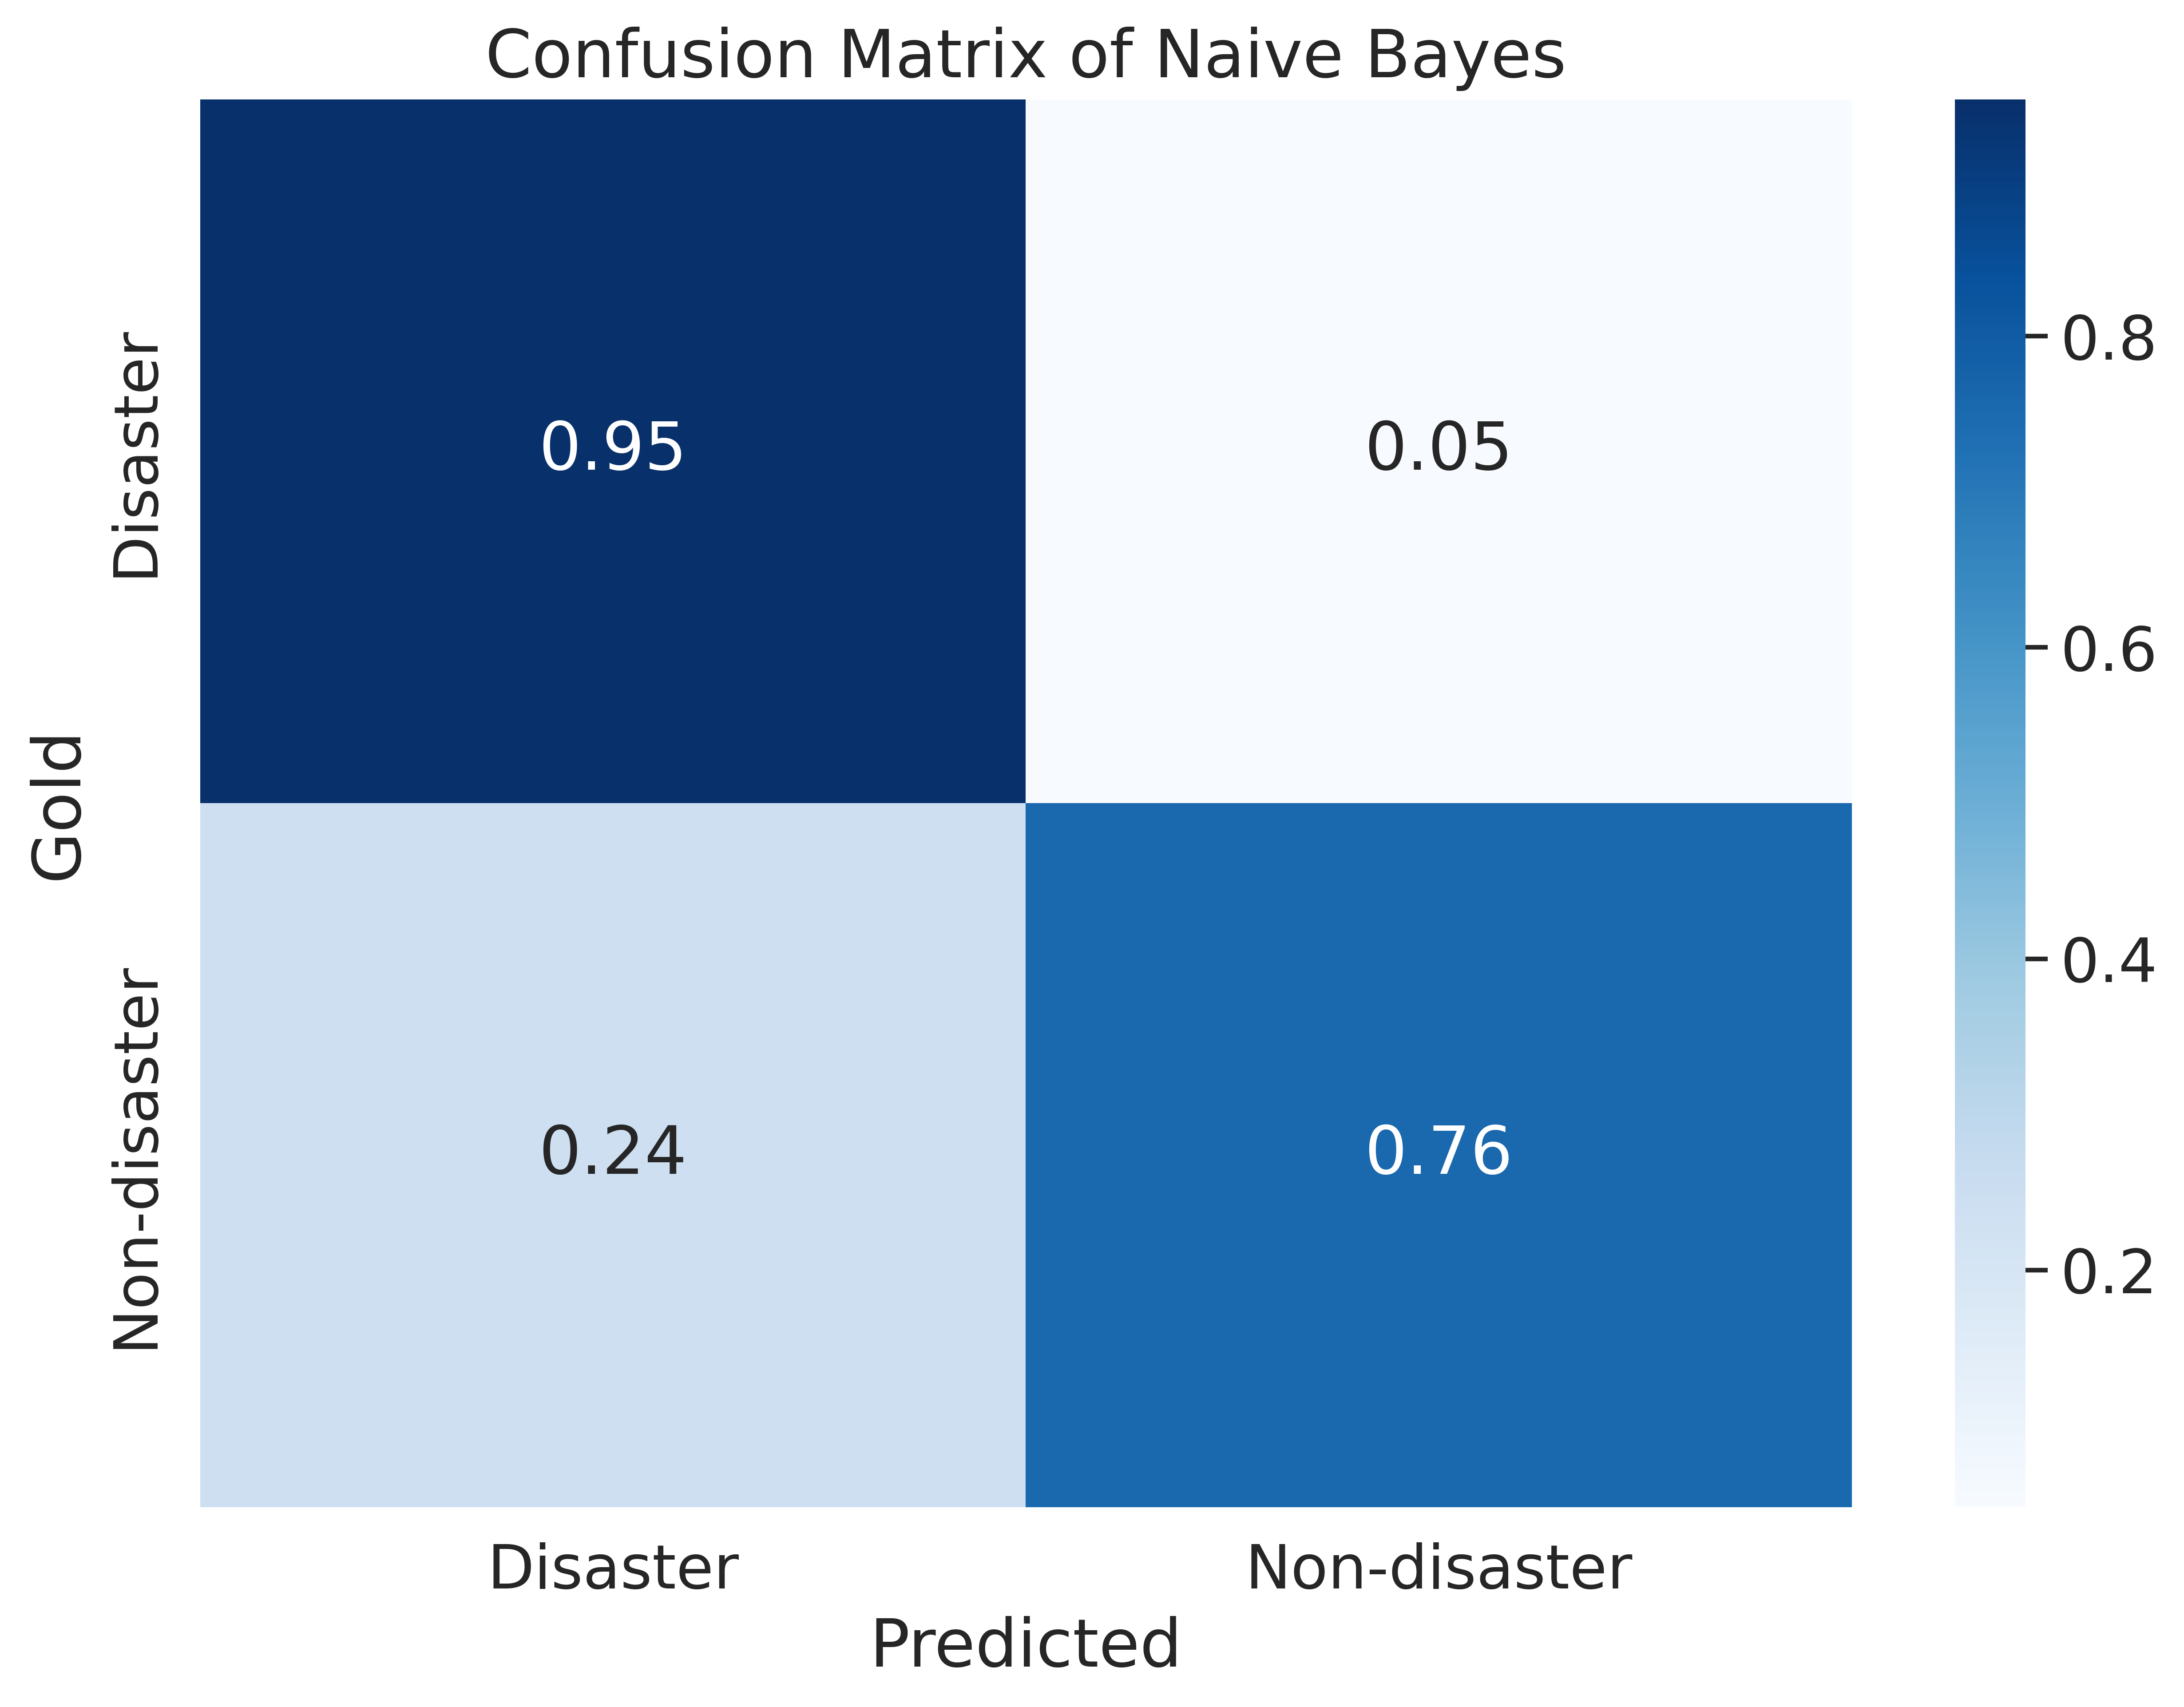

In [28]:
def plot_cm(confustion_matrix, title, columns,  normalized = False):
    if normalized:
        confustion_matrix = confustion_matrix.astype("float")/confustion_matrix.sum(axis = 1)[:, np.newaxis]
    plt.figure(figsize = (10,7), dpi = 600)
    cm = pd.DataFrame(data = confustion_matrix, columns=columns, index = columns)
    sns.set(font_scale = 1.5)
    sns.heatmap(cm, annot=True, fmt = ".2f", cmap = "Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Gold")
    plt.title(title)
    plt.show()
plot_cm(cm, "Confusion Matrix of Naive Bayes", ["Disaster", "Non-disaster"], True)

In [40]:
average_precision_score(test.target, predicted)

0.8042141117509047

In [38]:
recall_score(test.target, predicted, average='weighted')

0.8677758318739054

In [39]:
f1_score(test.target, predicted, average='weighted')

0.8654791668397012

In [41]:
vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=10000,
    output_mode='int',
    output_sequence_length=250)

In [42]:
train.head(5)

,target,clean_text
0,1,exploration take seismic shift gabon somalia
1,0,mind blow glassanimals slither viscous gold mi...
2,1,70 years atomic bomb japan still struggle war ...
3,1,come back camp return new song get record tomo...
4,0,dead space obliteration imminent 2 2 via youtube


In [43]:
#create dataloader
def create_dataset(df):
    clean_text = []
    target = []

    for i in range(len(df)):
        clean_text.append(df.iloc[i]['clean_text'])
        target.append(df.iloc[i]['target'])

    input1 = np.array(tuple(clean_text))
    input2 = np.array(tuple(target))
    train_dataset = tf.data.Dataset.from_tensor_slices((input1, input2))
    return train_dataset

In [44]:
test = test.rename(columns = {"text":"clean_text"})
train_dataset = create_dataset(train)
test_dataset = create_dataset(test)

In [45]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b'exploration take seismic shift gabon somalia'
label:  1


In [46]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [47]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [48]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b'one direction pick fan army directioners'
 b'royalcarribean passengers know mass murder take place faroeislands every year'
 b'thesewphist whoever hold address fuckface go deluge spam mean']

labels:  [0 1 0]


In [49]:
VOCAB_SIZE = 10000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [50]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'û', 'get', 'like', 'amp', 'fire', 'go', 'bomb',
       'new', 'via', 'people', 'say', 'one', 'news', 'kill', 'make',
       'burn', 'flood', 'crash'], dtype='<U29')

In [51]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  13, 1264,  222,  310,  125, 1416,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [3311,  940,   34,  131,  224,   43,  386, 2781,  180,   65,    0,
           0,    0,    0,    0,    0,    0],
       [5333, 3030,  332, 2961, 9122,    7,  139, 5766,  305,    0,    0,
           0,    0,    0,    0,    0,    0]])

In [52]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'one direction pick fan army directioners'
Round-trip:  one direction pick fan army directioners           

Original:  b'royalcarribean passengers know mass murder take place faroeislands every year'
Round-trip:  royalcarribean passengers know mass murder take place faroeislands every year       

Original:  b'thesewphist whoever hold address fuckface go deluge spam mean'
Round-trip:  thesewphist whoever hold address fuckface go deluge spam mean        



In [53]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [54]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [55]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.02285833]


In [56]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.02285833]


In [57]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
earlystop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10, restore_best_weights = True)
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", patience = 5, factor = 0.1)

In [58]:
history = model.fit(train_dataset, epochs=20,
                    validation_data=test_dataset,
                    validation_steps=30, callbacks = [earlystop, ReduceLR])

Epoch 1/20
84/84 [==============================] - 100s 335ms/step - loss: 0.6905 - accuracy: 0.5639 - val_loss: 0.6844 - val_accuracy: 0.5708
Epoch 2/20
84/84 [==============================] - 13s 150ms/step - loss: 0.6780 - accuracy: 0.5639 - val_loss: 0.6808 - val_accuracy: 0.5708
Epoch 3/20
84/84 [==============================] - 7s 77ms/step - loss: 0.5919 - accuracy: 0.5992 - val_loss: 1.5381 - val_accuracy: 0.5833
Epoch 4/20
84/84 [==============================] - 12s 135ms/step - loss: 0.4049 - accuracy: 0.8341 - val_loss: 1.0730 - val_accuracy: 0.7229
Epoch 5/20
84/84 [==============================] - 13s 155ms/step - loss: 0.3105 - accuracy: 0.8810 - val_loss: 0.9552 - val_accuracy: 0.7781
Epoch 6/20
84/84 [==============================] - 4s 52ms/step - loss: 0.2483 - accuracy: 0.9065 - val_loss: 0.5519 - val_accuracy: 0.8458
Epoch 7/20
84/84 [==============================] - 5s 57ms/step - loss: 0.2002 - accuracy: 0.9287 - val_loss: 0.4768 - val_accuracy: 0.8760
Epoc

In [59]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

36/36 [==============================] - 4s 7ms/step - loss: 0.4622 - accuracy: 0.8757
Test Loss: 0.4621555805206299
Test Accuracy: 0.8756567239761353


(0.0, 1.6112881891429425)

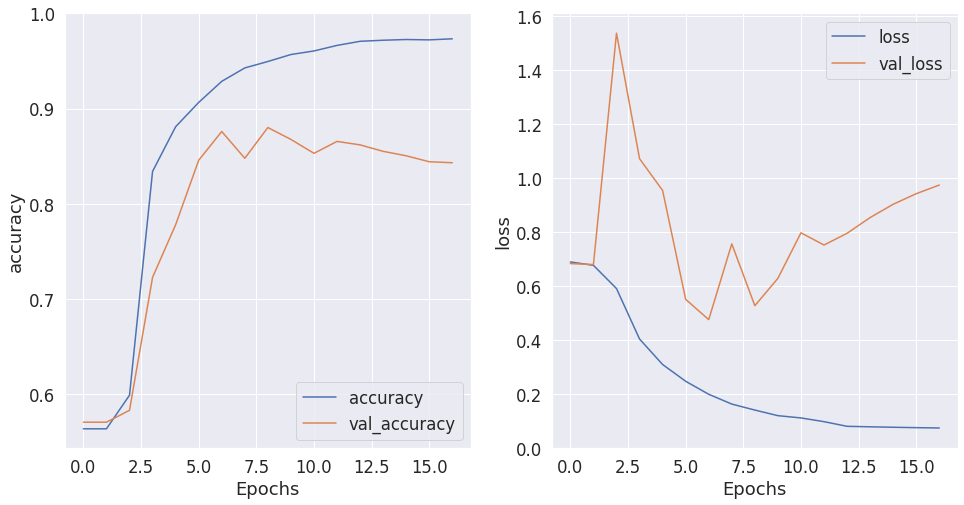

In [60]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

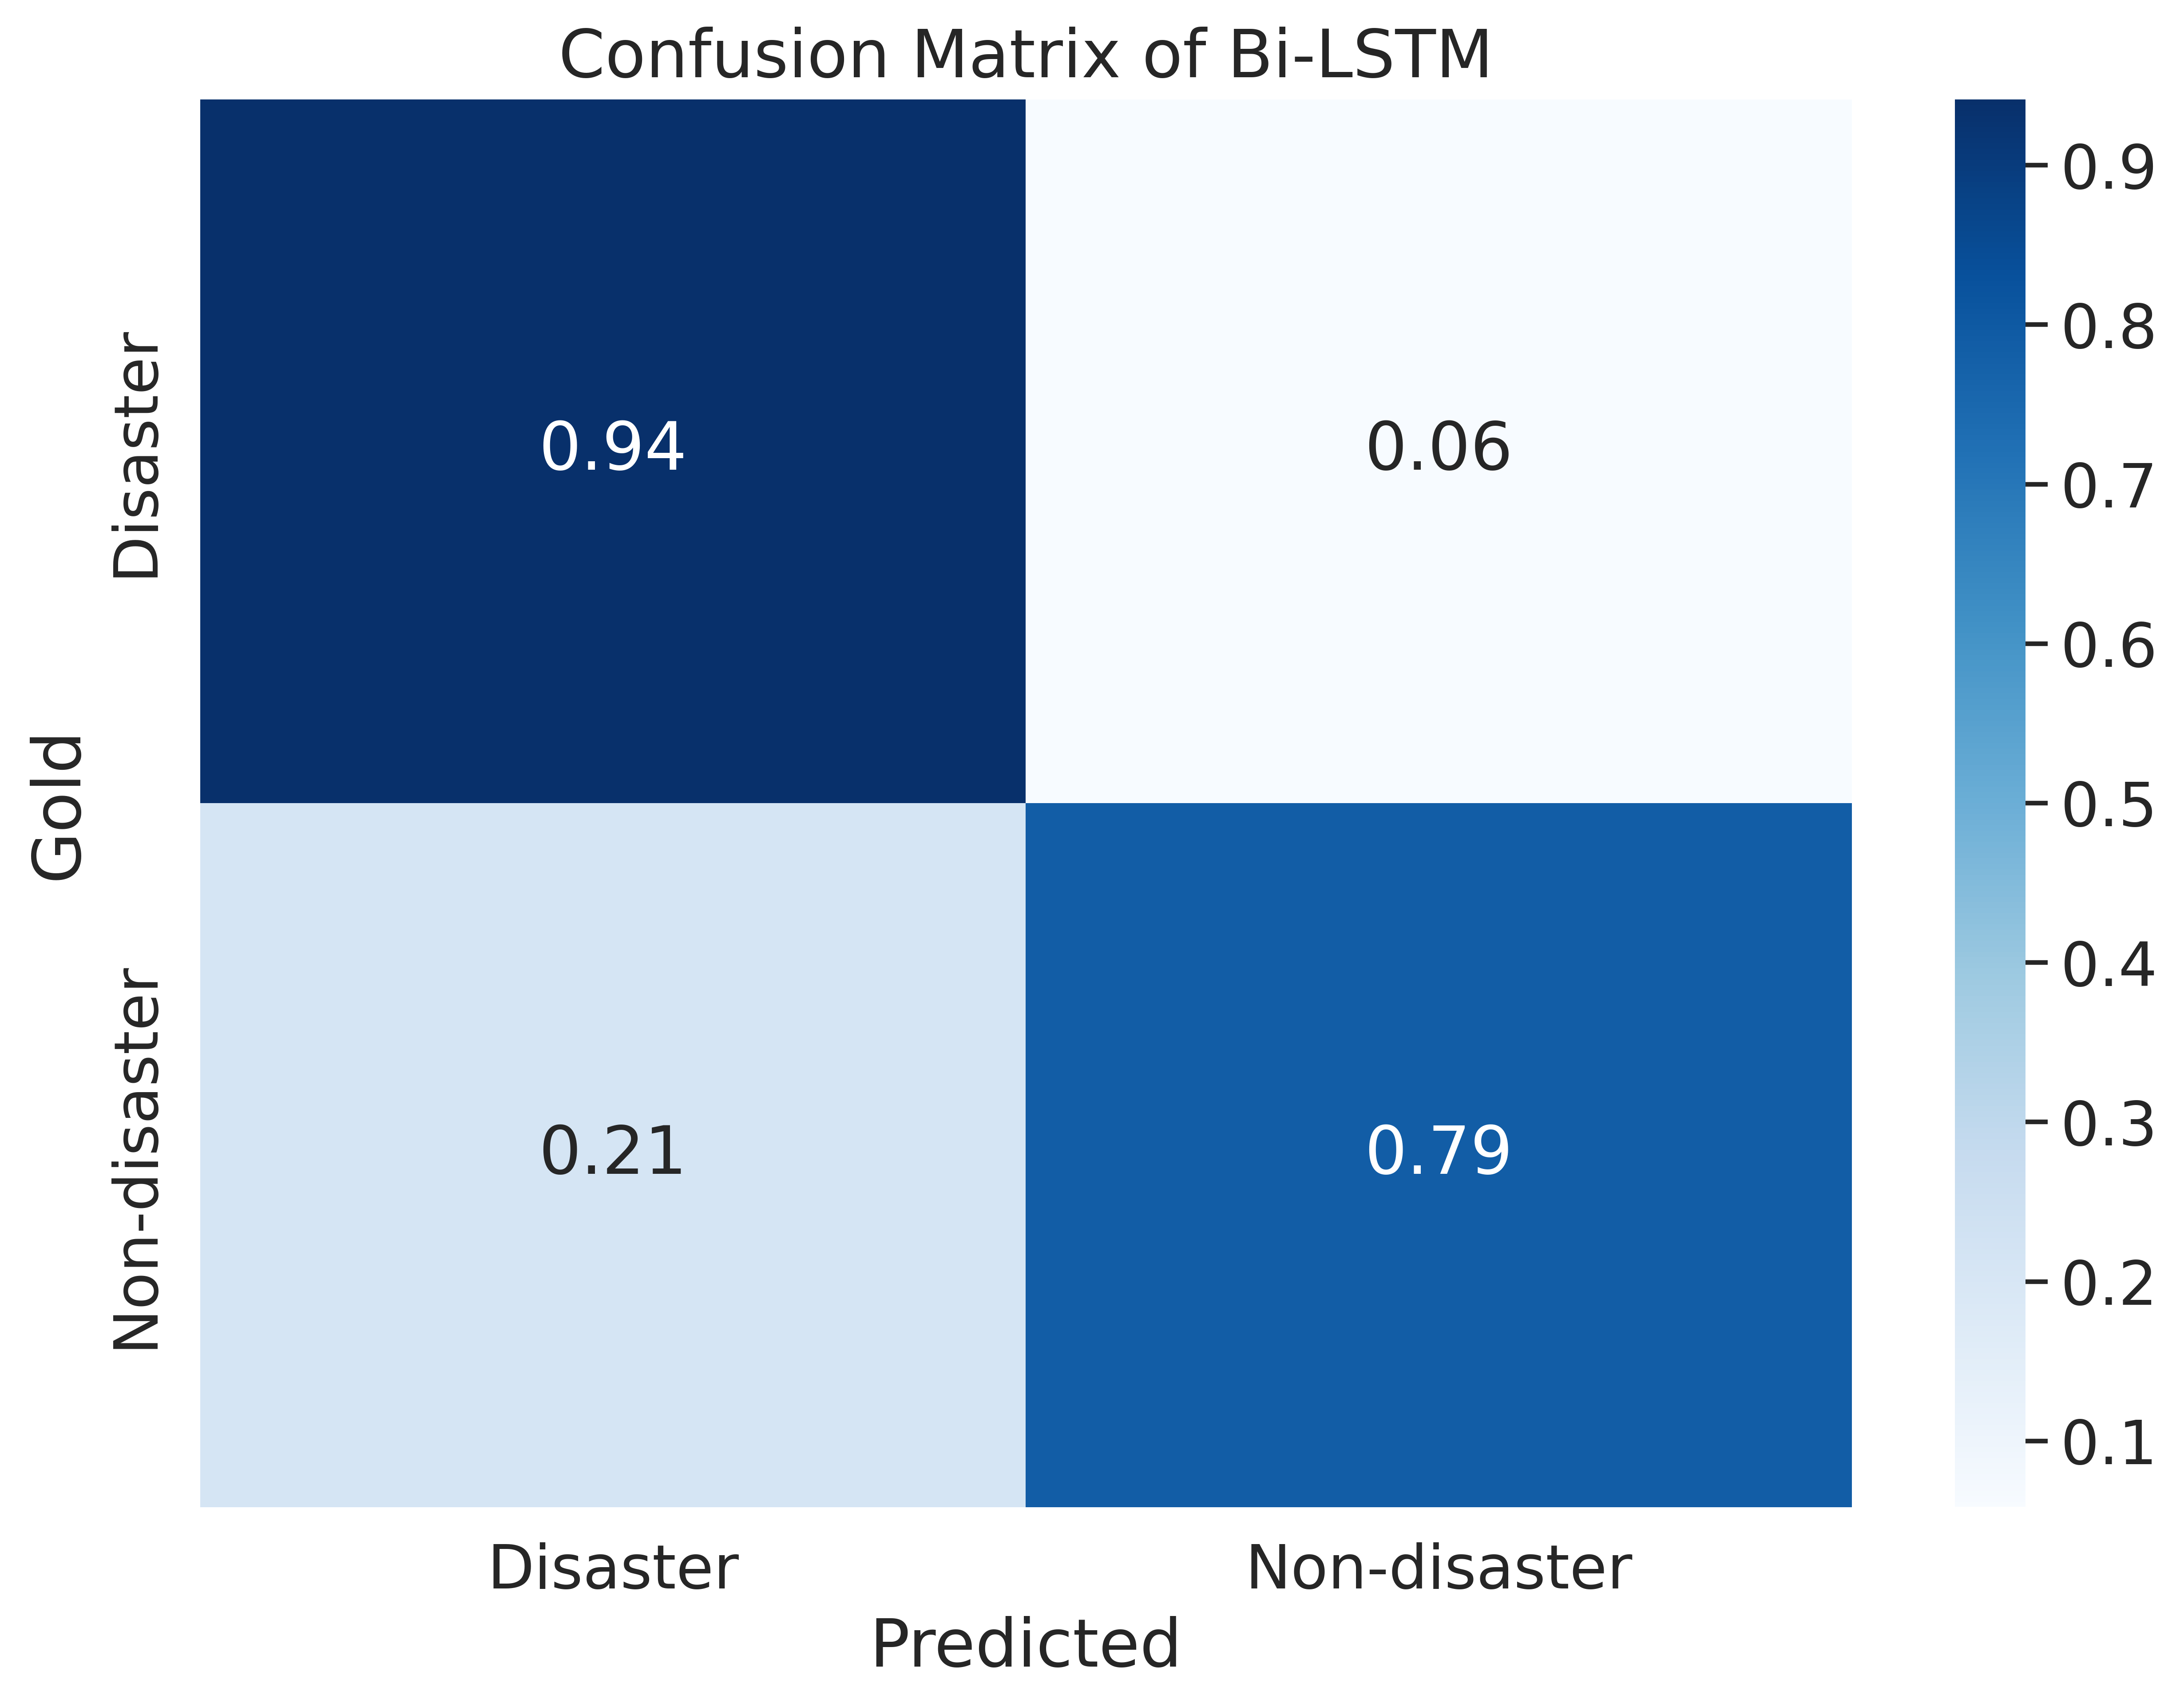

In [61]:
pred = model.predict(test_dataset)
pred_class = np.where(pred<0.5, 0, 1)
cm = confusion_matrix(test['target'], pred_class)
plot_cm(cm, "Confusion Matrix of Bi-LSTM", ["Disaster", "Non-disaster"], True)

In [62]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [63]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
earlystop = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 10, restore_best_weights = True)
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_accuracy", patience = 5, factor = 0.1)

In [64]:
history = model.fit(train_dataset, epochs=40,
                    validation_data=test_dataset,
                    validation_steps=30, callbacks = [earlystop, ReduceLR])

Epoch 1/40
84/84 [==============================] - 171s 784ms/step - loss: 0.6921 - accuracy: 0.5639 - val_loss: 0.6899 - val_accuracy: 0.5708
Epoch 2/40
84/84 [==============================] - 10s 112ms/step - loss: 0.6878 - accuracy: 0.5639 - val_loss: 0.6826 - val_accuracy: 0.5708
Epoch 3/40
84/84 [==============================] - 14s 157ms/step - loss: 0.6424 - accuracy: 0.5883 - val_loss: 0.8457 - val_accuracy: 0.5823
Epoch 4/40
84/84 [==============================] - 12s 131ms/step - loss: 0.4366 - accuracy: 0.8200 - val_loss: 0.7998 - val_accuracy: 0.7089
Epoch 5/40
84/84 [==============================] - 10s 121ms/step - loss: 0.3263 - accuracy: 0.8788 - val_loss: 0.5733 - val_accuracy: 0.8120
Epoch 6/40
84/84 [==============================] - 11s 130ms/step - loss: 0.2622 - accuracy: 0.9101 - val_loss: 0.4757 - val_accuracy: 0.8589
Epoch 7/40
84/84 [==============================] - 18s 215ms/step - loss: 0.2188 - accuracy: 0.9289 - val_loss: 0.5784 - val_accuracy: 0.862

In [65]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

36/36 [==============================] - 3s 14ms/step - loss: 0.4768 - accuracy: 0.8796
Test Loss: 0.47681349515914917
Test Accuracy: 0.8795971870422363


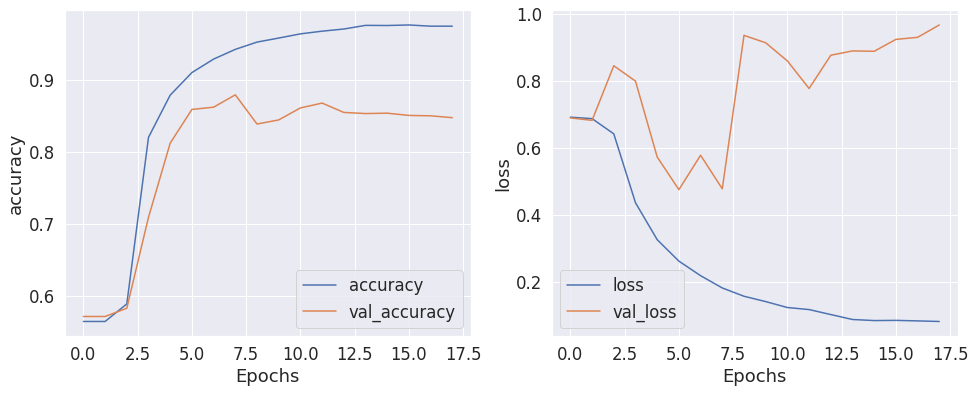

In [66]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [67]:
pred = model.predict(test_dataset)

In [68]:
pred_class = np.where(pred<0.5, 0, 1)

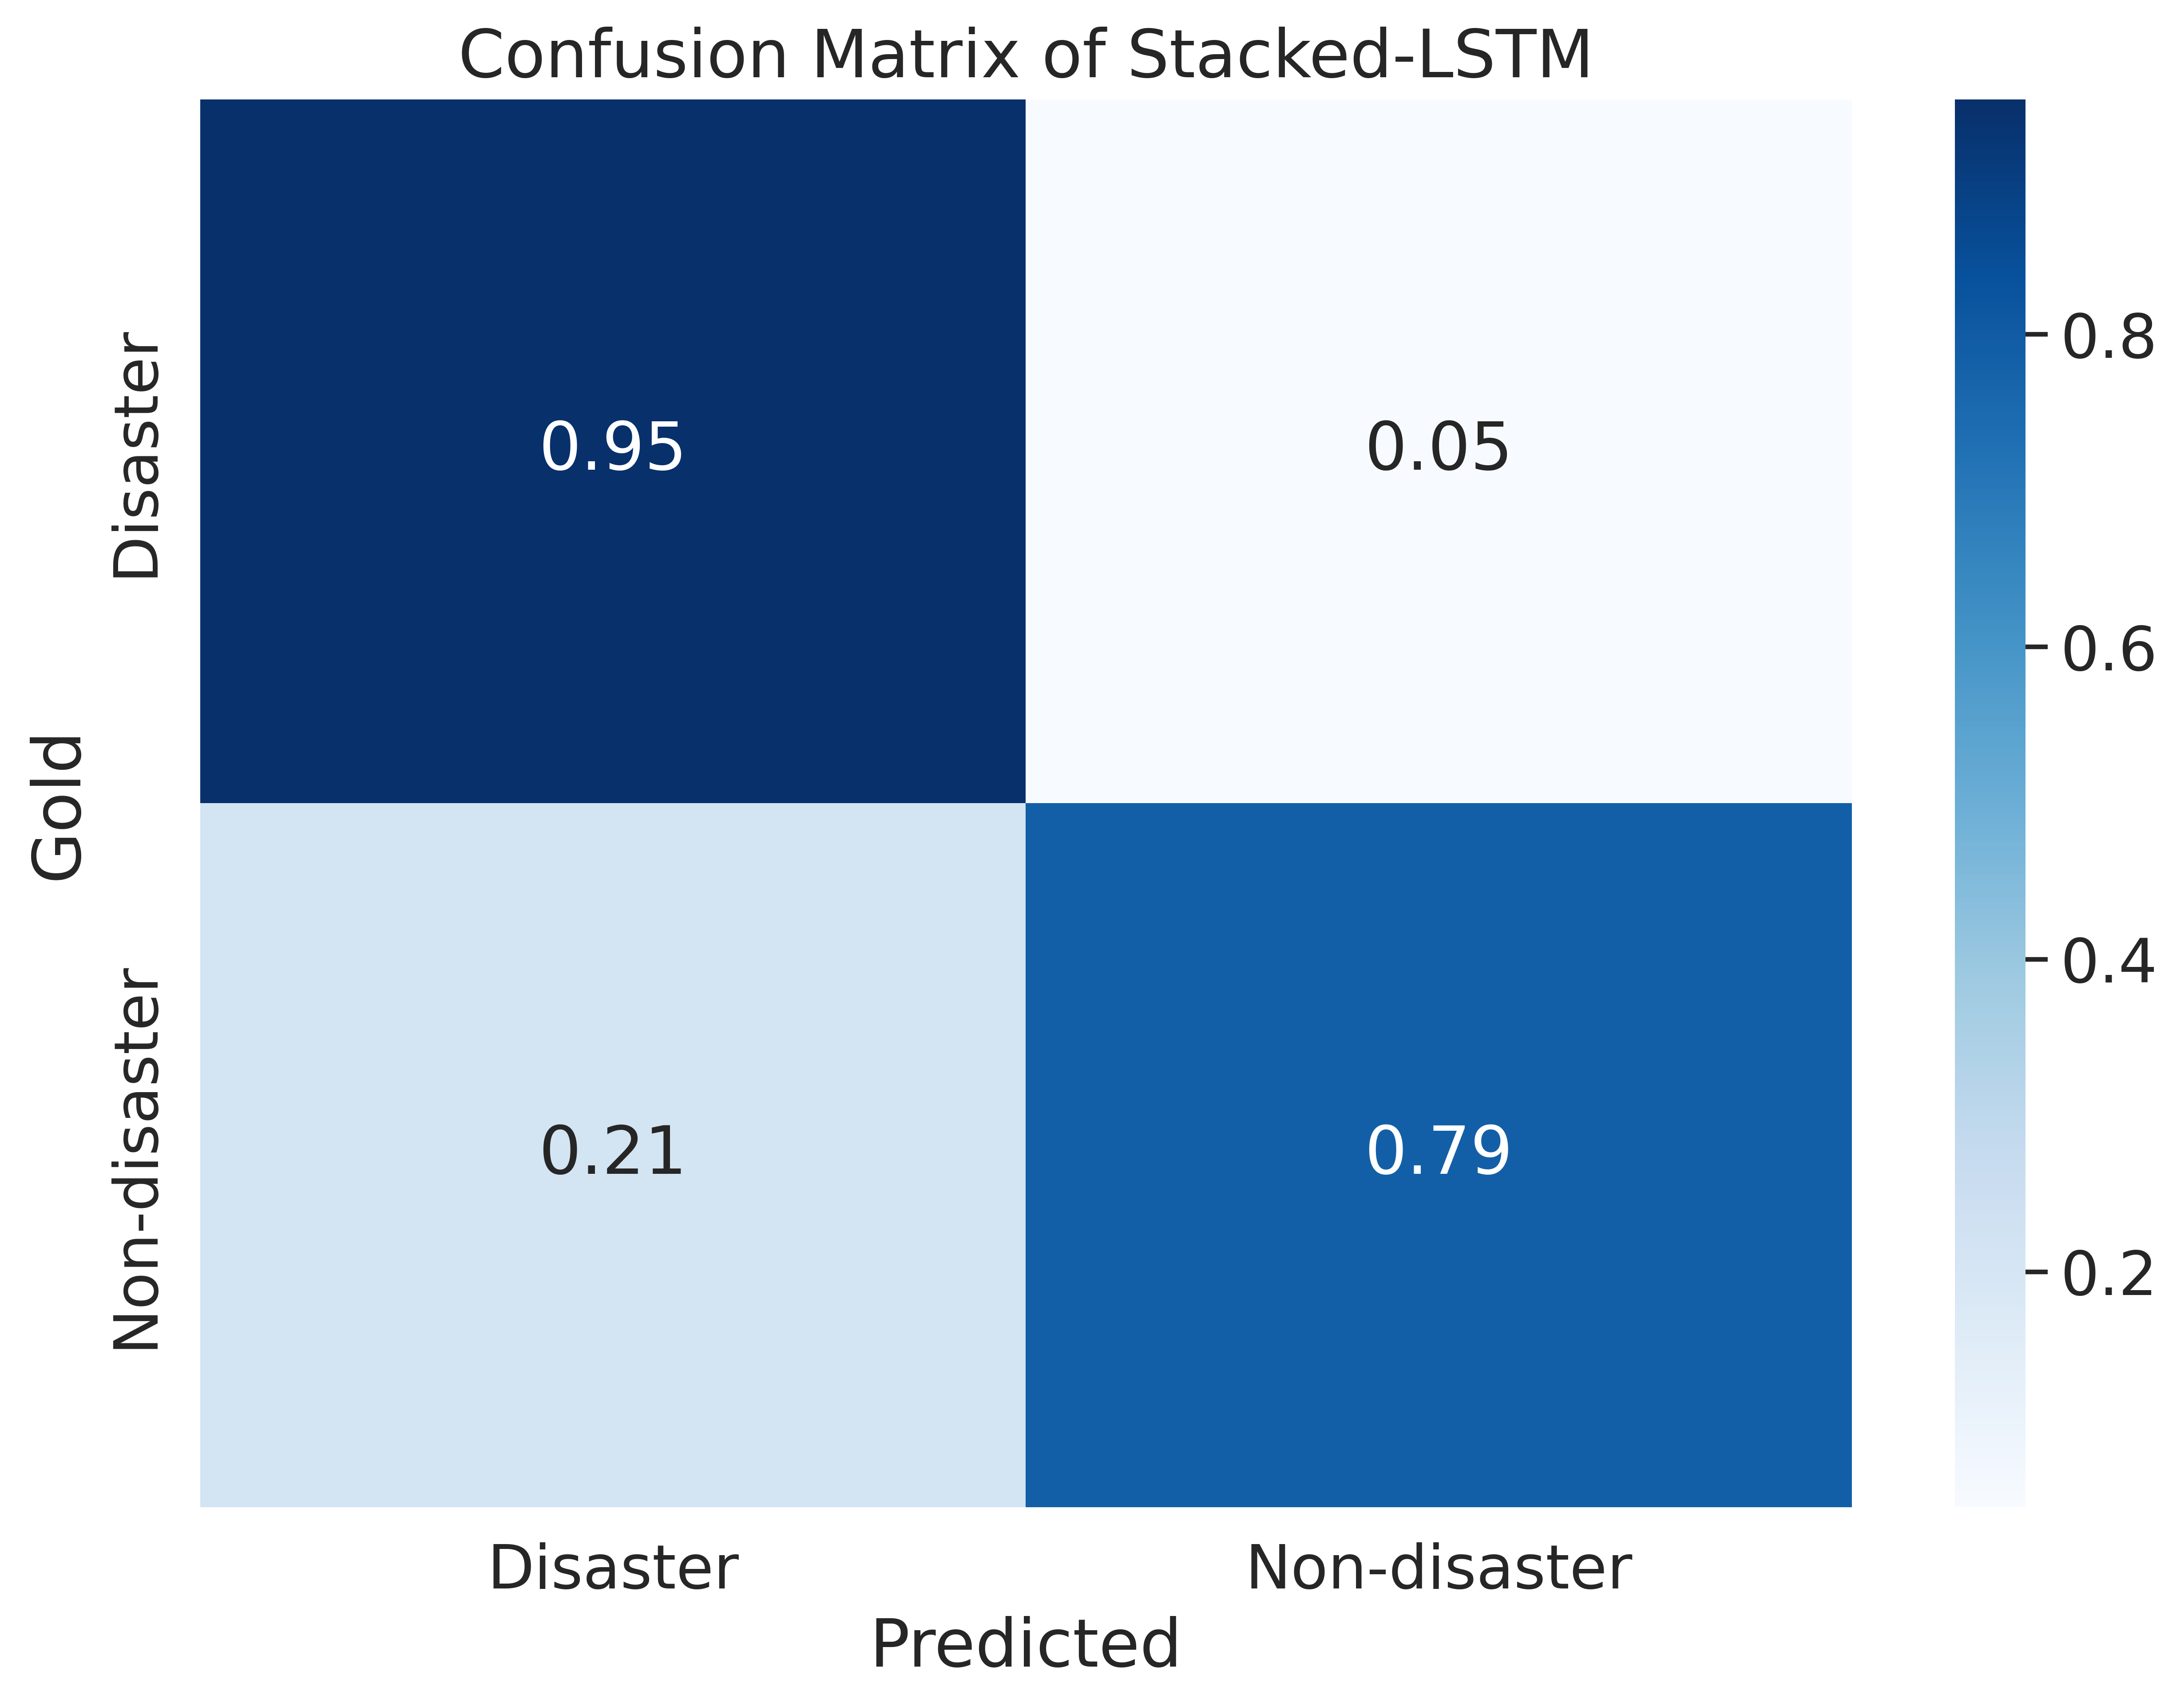

In [70]:
cm = confusion_matrix(test['target'], pred_class)
plot_cm(cm, "Confusion Matrix of Stacked-LSTM", ["Disaster", "Non-disaster"], True)

In [71]:
average_precision_score(test.target, pred_class)

0.8189712523215482

In [72]:
recall_score(test.target, pred_class, average='weighted')

0.8795971978984238

In [73]:
f1_score(test.target, pred_class, average='weighted')

0.8779896660425719